# Mathematics of Arrays (MOA)

# TOC

 - [Introduction](0-introduction.ipynb)
 - [Simple Example](1-simple-example.ipynb)
 - [Simple Example Symbolic](2-simple-example-symblic.ipynb)
 - [Pythonic MOA Array Interface](3-lazy-arrays.ipynb)
 - [Benchmarks](4-benchmarks.ipynb)

# Project

 - [documentation](https://python-moa.readthedocs.io/en/latest/) python-moa.readthedocs.com
 - [binder demo](https://mybinder.org/v2/gh/Quansight-Labs/python-moa/master) 
 - [repository](https://github.com/Quansight-Labs/python-moa) Quansight-Labs/python-moa
 - [benchmarks/testing](https://travis-ci.org/Quansight-Labs/python-moa) numpy, numba, pytorch, tensorflow
 - [100% reproducible](https://github.com/Quansight-Labs/python-moa/blob/master/dev.nix) builds, testing, demos, and docs

## What is an Array?

 - scalar `shape = ()`
 - vector `shape = (n,)`
 - matrix `shape = (n, m)`
 - n-dimensional array `shape = (n, m, ...., z)`
 
## What has a shape in MOA?

Everything! this is the key to composability

 - Arrays
 - operations `A + B` the operation `+` results in a shape
 - functions `f(A, B, C) -> D`

## What is MOA?

A theory that reduces operations on arrays that is motivated by two important properties.
  - what is the shape?
  - what is the indexing?
  
## What is currently implemented

 - symbolic and numeric parser
 - pythonic interface that generates moa internal representation `LazyArray`
 - as long as the dimension is known at compile time the moa compiler works 
    - it is known and not hard to relax this restriction to only needing an upper bound on dimension
 - indexing (not slicing)
 - binary operations (+-*/)
 - outer product (+-*/)
 - transpose, arbitrary transpose `(n m l) -> (m n l)`
  
# What are the MOA steps?
  
## Example $((A+B).T)[0]$

We could do symbolic and much more complex calculations (the tree just isn't as nice to look at and harder to explain).

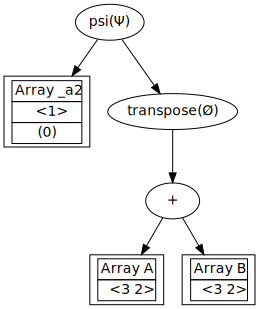

In [1]:
from moa.frontend import LazyArray

A = LazyArray(name='A', shape=(3, 2))
B = LazyArray(name='B', shape=(3, 2))

expression = ((A + B).T)[0]
expression.visualize()

# Shape

We calculate the shape of each node in the tree via a single pass [postorder](https://en.wikipedia.org/wiki/Tree_traversal) traversal. Okay so what does this give us?

1. We know the resulting shape of the computation and can allocate the memory.
2. We can guarentee past this stage that the program is valid, terminates, and has no out of bound memory errors
  - this is why MOA could be extremely compelling for FPGAs and compute units

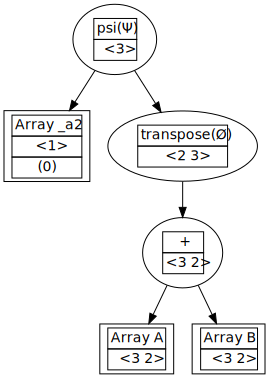

In [2]:
expression.visualize(stage='shape')

# DNF Reduction

We calculate the dnf via a single pass [preorder](https://en.wikipedia.org/wiki/Tree_traversal) traversal. It is the **minimal** representation of the algorithm, is machine independent, and has the [church-rosser](https://en.wikipedia.org/wiki/Church%E2%80%93Rosser_theorem) property.

We have removed the `transpose` operation and we are now only computing what we need!

 - moa will not miss these reductions (your compiler most likely will)
 - we can now do analysis on algorithms! Memory usage heatmap, total flops, predict cache misses, etc.

In [3]:
expression.analysis()

{'unoptimized_flops': 6, 'optimized_flops': 3}

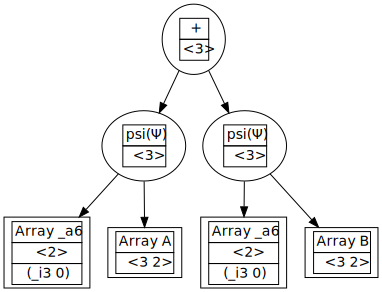

In [4]:
expression.visualize(stage='dnf')

# ONF / Backend

ONF is the process of mapping a reduced algorithm to machine hardware. This is a complex topic becuase in theory this has many directions.

It is not moa's reponsibility to write the backend but to provide low level primitives that easily map to hardware/software implementations.
 
 - sparse/dense row/column array format?
 - distributed?
 - gpu?
 - tensor cores?
 - cpu?
 - cache size?
 - network latency/bandwidth?
  
This is an optimization problem. The key is that the DNF is independent of this. Guarenteeing us that we have the minimal algorithm. Adding to why it is so important that MOA is modular.

PSI reduction (not implmented) plays a key role by allowing us to minimize the number of loops in our algorithm into contiguous chunks of memory (independent from the dimensionality of each array). This will enable us to compete with.

In [5]:
print(expression.compile(use_numba=True))



@numba.jit
def f(A, B):
    
    
    if (not ((len(B.shape) == 2) and (len(A.shape) == 2))):
        
        raise Exception('arguments have invalid dimension')
    
    if (not ((2 == B.shape[1]) and ((3 == B.shape[0]) and ((2 == A.shape[1]) and (3 == A.shape[0]))))):
        
        raise Exception('arguments do not match declared shape')
    
    _a17 = numpy.zeros((3,))
    
    for _i3 in range(0, 3, 1):
        
        _a17[(_i3,)] = (A[(_i3, 0)] + B[(_i3, 0)])
    return _a17


# Benchmarks

moa numba vs numpy and symbolics

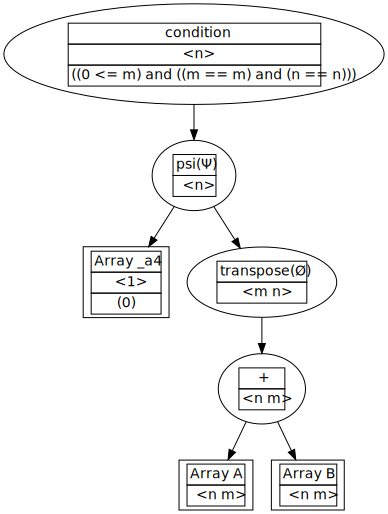

In [6]:
from moa.frontend import LazyArray

A = LazyArray(name='A', shape=('n', 'm'))
B = LazyArray(name='B', shape=('n', 'm'))

expression = ((A + B).T)[0]
expression.visualize('shape')

In [18]:
print(expression.compile(use_numba=True))



@numba.jit
def f(A, B):
    
    
    if (not ((len(B.shape) == 2) and (len(A.shape) == 2))):
        
        raise Exception('arguments have invalid dimension')
    
    n = A.shape[0]
    
    m = A.shape[1]
    
    n = B.shape[0]
    
    m = B.shape[1]
    
    if (not ((0 <= m) and ((m == m) and (n == n)))):
        
        raise Exception('arguments have incompatible shape')
    
    _a16 = numpy.zeros((n,))
    
    for _i6 in range(0, n, 1):
        
        _a16[(_i6,)] = (A[(_i6, 0)] + B[(_i6, 0)])
    return _a16


In [7]:
import numba
import numpy

n = 1000
m = 1000

A = numpy.random.random((n, m))
B = numpy.random.random((n, m))

exec(expression.compile(use_numba=True))

In [9]:
%%timeit

f(A=A, B=B)

3.76 µs ± 8.39 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit

# lets show numpy worst case
((A + B).T)[0]

1.83 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit

# lets be smart
(A[:, 0] + B[:, 0]).reshape((m,))

7.29 µs ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
@numba.jit
def g(A, B):
    return ((A + B).T)[0]

In [13]:
%%timeit

# numba/llvm doesn't optimize array operations
g(A, B)

1.86 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
@numba.jit
def g(A, B):
    return (A[:, 0] + B[:, 0]).reshape((m,))

In [16]:
%%timeit

# now we get the same performance
g(A, B)

3.24 µs ± 8.58 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# FAQ

## Does it have `<blank>` operation?
    
If it satisfies the shape and indexing conditions then yes. MOA is not a language spec it is a theory for conformable and reducable operations.    

## How can MOA do indexing without caring about layout?

Suppose an array `A` has shape `(2, 3, 4)`. Then index `(0, 1, 1)` maps to element 5. Notice how there is an assumption of shape mapping an index in row major order (this is only convention). But we have not said *anything* about the layout of the array `A` in memory. 

Array `A(shape, psi)`. It is the reposonsibility of `psi(i)` to map an index `i` to a memory localtion `0x1ef18ba...`

## What is dimension lifting and how is it useful?

Suppose an array `A` has shape `(100, 100)` and we have 10 processors. Traditionally you would tile `A[:50, :50]` or select a subset of rows `A[:10]`. Lets look at it a different way.

When we lift the dimension to `(10, 10, 100)`. The total number of elements is the same 10,000 and continuity of memory is preserved.

MOA makes "blocking" of arrays easy

# Roadmap

 - (+-*/) reduce
    - the foundation of almost any algorithm
 - einsum notation (excluding trace needs rotate operation)
    - matrix multiply, tensor contractions, norms, **n**blas
 - psi reduction (start, stop, stride)
    - drop, take, rotate
    - minimize loops
    - *huge* performance improvement will be at a minimum competative with others
 - MOA array interface with numerical routines
    - annotation to numerical routines
 - sequence of moa operations
    - LU factorization
    - QR
    - Gradient Decent
